In [15]:
!pip install timm
!pip install einops

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from timm.utils import ModelEmaV3
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

#positional embeddings
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        embeds = torch.reshape(embeds, (1,-1))
        return embeds[:, :, None]

In [2]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [3]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        length = x.shape[2]
        x = rearrange(x, 'b c l -> b l c')
        x = self.proj1(x)
        x = rearrange(x, 'b l (C H K) -> K b H l C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H l C -> b l (C H)')
        x = self.proj2(x)
        return rearrange(x, 'b l C -> b C l')

In [4]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            last_layer: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale and not last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1)
        elif last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1, output_padding=1)
        else:
            self.conv = nn.Conv1d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [5]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            last_layers: List = [False, False, False, False, False, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv1d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv1d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv1d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                last_layer=last_layers[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [6]:
model = UNET()

# Generate a random 1D input tensor of shape (batch_size, input_channels, length)
batch_size = 1  # You can change this to whatever batch size you need
input_length = 34  # As specified
input_tensor = torch.randn(batch_size, 1, input_length)  # Shape: (1, 1, 34)

# Generate a random time step tensor
time_steps = torch.randint(0, 1000, (batch_size,))  # Randomly generating time steps

# Pass the input tensor through the model
output = model(input_tensor, time_steps)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 34])


In [7]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [8]:
data = np.load('/home/nnara/notebooks/1mil_pixel_data.npy')
#reshape it to (size, channels, length)
data = data.reshape((-1, 1, 34))

In [9]:
class SpectralDataset(Dataset):
  def __init__(self, data):
    self.data = torch.from_numpy(data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [19]:
import os
def train(batch_size: int=250,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          checkpoint_path: str=None):
    #set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = SpectralDataset(data)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_dataloader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            #x = x.unsqueeze(1)
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1).cuda()
            
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (1000000/batch_size):.5f}')
    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, '/home/nnara/notebooks/ddpm_checkpoint.pth')

    

In [29]:
train(checkpoint_path='/home/nnara/notebooks/ddpm_checkpoint.pth', lr=2e-5, num_epochs=20)

/tmp/ipykernel_3605824/2429892597.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Epoch 1/20: 100%|███████████████████████████|

Epoch 1 | Loss 0.02316


Epoch 2/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.75it/s]


Epoch 2 | Loss 0.02310


Epoch 3/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.68it/s]


Epoch 3 | Loss 0.02318


Epoch 4/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.80it/s]


Epoch 4 | Loss 0.02313


Epoch 5/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.81it/s]


Epoch 5 | Loss 0.02316


Epoch 6/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.86it/s]


Epoch 6 | Loss 0.02320


Epoch 7/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.77it/s]


Epoch 7 | Loss 0.02308


Epoch 8/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.80it/s]


Epoch 8 | Loss 0.02311


Epoch 9/20: 100%|███████████████████████████| 4000/4000 [01:33<00:00, 42.84it/s]


Epoch 9 | Loss 0.02315


Epoch 10/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.80it/s]


Epoch 10 | Loss 0.02319


Epoch 11/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.77it/s]


Epoch 11 | Loss 0.02309


Epoch 12/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.80it/s]


Epoch 12 | Loss 0.02318


Epoch 13/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.81it/s]


Epoch 13 | Loss 0.02322


Epoch 14/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.83it/s]


Epoch 14 | Loss 0.02303


Epoch 15/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.82it/s]


Epoch 15 | Loss 0.02304


Epoch 16/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.82it/s]


Epoch 16 | Loss 0.02309


Epoch 17/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.68it/s]


Epoch 17 | Loss 0.02300


Epoch 18/20: 100%|██████████████████████████| 4000/4000 [01:33<00:00, 42.72it/s]


Epoch 18 | Loss 0.02302


Epoch 19/20: 100%|██████████████████████████| 4000/4000 [01:34<00:00, 42.53it/s]


Epoch 19 | Loss 0.02311


Epoch 20/20: 100%|██████████████████████████| 4000/4000 [01:34<00:00, 42.50it/s]


Epoch 20 | Loss 0.02306


In [30]:
class DDIM_Scheduler(nn.Module):
    def __init__(self, num_time_steps=1000):
        super().__init__()
        self.num_time_steps = num_time_steps
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

    def ddim_update(self, model_output, x, t, t_next):
        alpha_t = self.alpha_cumprod[t].view(-1, 1, 1).cuda()
        alpha_t_next = self.alpha_cumprod[t_next].view(-1, 1, 1).cuda() if t_next >= 0 else torch.ones_like(alpha_t)

        # Predict x_0 (denoised image)
        pred_x0 = (x - torch.sqrt(1 - alpha_t) * model_output) / torch.sqrt(alpha_t)

        # Calculate the DDIM update step
        direction = torch.sqrt(1 - alpha_t_next) * model_output
        x_next = torch.sqrt(alpha_t_next) * pred_x0 + direction

        return x_next

In [34]:
def ddim_inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              num_inference_steps: int=50,
              ema_decay: float=0.9999):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDIM_Scheduler(num_time_steps=num_time_steps)
    spectra = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(5):  # Generate 100 spectra
            z = torch.randn(1, 1, 34).cuda()  # Initial noise

            timesteps = torch.linspace(0, num_time_steps - 1, num_inference_steps).long().flip(0)

            for idx, t in enumerate(timesteps[:-1]):
                t_next = timesteps[idx + 1]
                t = t.cuda()
                model_output = model(z, t)

                z = scheduler.ddim_update(model_output, z, t, t_next)

            model_output = model(z, timesteps[-1].cuda())
            z = scheduler.ddim_update(model_output, z, timesteps[-1].cuda(), -1)

            x = z.squeeze(0).cpu().detach().numpy()
            spectra.append(x)
    return spectra

In [35]:
spectra = ddim_inference('/home/nnara/notebooks/ddpm_checkpoint.pth')

/tmp/ipykernel_3605824/3034127496.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [20]:
data = np.load("/home/nnara/notebooks/1mil_pixel_data.npy")

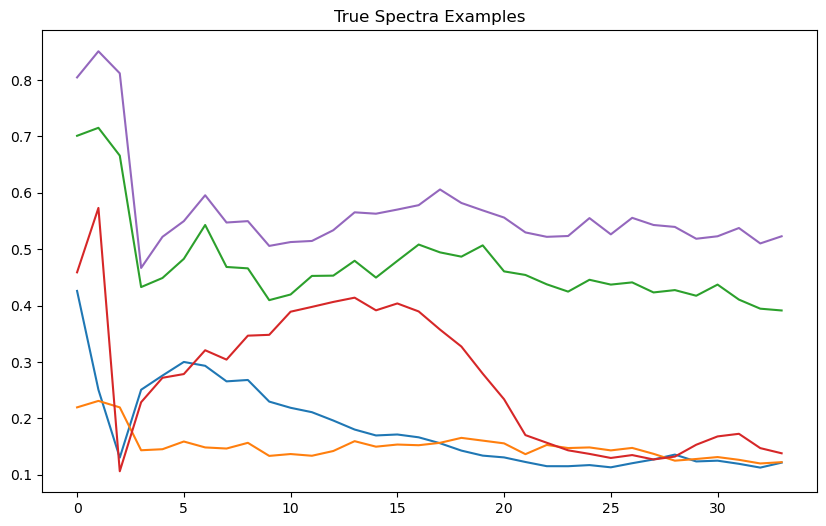

In [29]:
import random
plt.figure(figsize=(10, 6))
for i in range(5):
  rand = random.randint(0,10000)
  plt.plot(data[rand])
plt.title("True Spectra Examples");

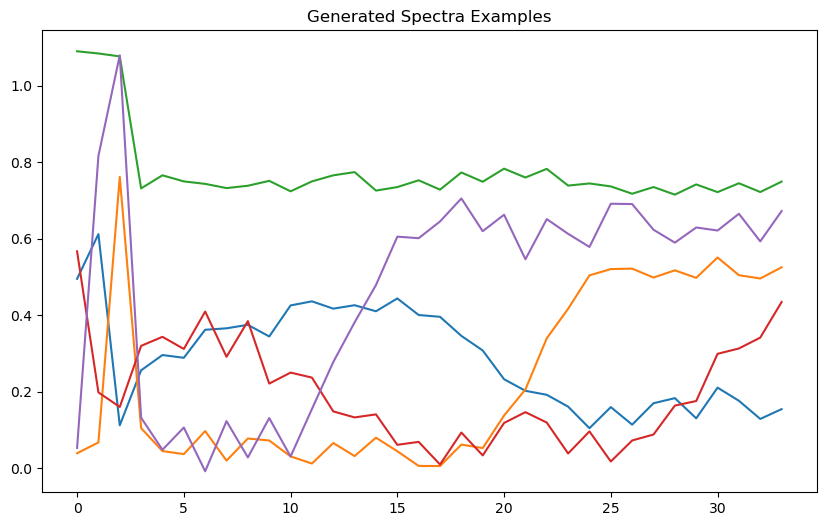

In [36]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

for i, spectrum in enumerate(spectra):
    spectrum = spectrum.squeeze()


    plt.plot(range(34), spectrum)


plt.title('Generated Spectra Examples');